In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from IPython.core.display import display
from kornia import image_to_tensor, tensor_to_image
from kornia.augmentation import ColorJitter, RandomChannelShuffle, RandomThinPlateSpline
from kornia.augmentation import RandomVerticalFlip, RandomHorizontalFlip, Resize, RandomCrop, RandomMotionBlur
from kornia.augmentation import RandomEqualize, RandomGaussianBlur, RandomGaussianNoise, RandomSharpness
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor

from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import GTSRB
from sklearn.metrics import ConfusionMatrixDisplay

import uncertain_fusion
import evidence_loss

from torch.distributions.dirichlet import Dirichlet
from torch.distributions.categorical import Categorical

sn.set()

/tmp/ipykernel_27309/4264160169.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [4]:
# CONSTANTS 

CM_FILE_NAME = 'gtsrb_train_cm_mobilenet.npy'

In [5]:
class DataAugmentation(nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self, apply_color_jitter: bool = False) -> None:
        super().__init__()
        self._apply_color_jitter = apply_color_jitter

        self.transforms = nn.Sequential(
            #RandomHorizontalFlip(p=0.50),
            RandomChannelShuffle(p=0.50),
            RandomThinPlateSpline(p=0.50),
            RandomEqualize(p=0.5),
            RandomGaussianBlur((3, 3), (0.1, 2.0), p=0.2),
            RandomGaussianNoise(mean=0., std=1., p=0.2),
            RandomSharpness(0.5, p=0.5)
        )

        self.jitter = ColorJitter(0.5, 0.5, 0.5, 0.5)

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Tensor) -> Tensor:
        #x = torch.squeeze(x, dim=1)
        x_out = self.transforms(x)  # BxCxHxW
        if self._apply_color_jitter:
            x_out = self.jitter(x_out)
        return x_out
    
class Preprocess(nn.Module):
    """Module to perform pre-process using Kornia on torch tensors."""
    def __init__(self) -> None:
        super().__init__()
        self.resize = Resize(size=(64,64))
        self.crop = RandomCrop(size=(64,64), cropping_mode="slice")

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x) -> Tensor:
        x_tmp: np.ndarray = np.array(x)  # HxWxC
        x_out: Tensor = image_to_tensor(x_tmp, keepdim=True)  # CxHxW
        x_out: Tensor = self.crop(x_out.float()).squeeze(dim=0)
        return x_out.float() / 255.0

In [38]:
class EvidentialUncertainFusionTTA(LightningModule):
    def __init__(self):
        super().__init__()
        self.n_classes = 43
        # not the best model: expereiment yourself
        #self.model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
        self.model = torchvision.models.mobilenet_v3_small(weights="IMAGENET1K_V1")
        self.model.classifier = nn.Sequential(
                                    nn.Linear(in_features=576, out_features=1024, bias=True),
                                    nn.Hardswish(),
                                    nn.Dropout(p=0.2, inplace=True),
                                    nn.Linear(in_features=1024, out_features=self.n_classes, bias=True)
                                  )
        self.preprocess = Preprocess()  # per sample transforms
        self.transform = DataAugmentation()  # per batch augmentation_kornia
        #self.flip = RandomHorizontalFlip(p=1.0)#testtime augmentation
        self.flip =  RandomMotionBlur(3, 35., 0.5, p=1.)
        
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
        self.val_flip_accuracy = torchmetrics.Accuracy()
        self.ds_fusion_accuracy = torchmetrics.Accuracy()
        self.bayes_fusion_accuracy = torchmetrics.Accuracy()
        self.dampster_fusion_accuracy = torchmetrics.Accuracy()
        self.sum_fusion_accuracy = torchmetrics.Accuracy()
        self.mean_fusion_accuracy = torchmetrics.Accuracy()
        
        
        
        
        self.train_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes, normalize='true')
        self.valid_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        
        self.DS_combine = uncertain_fusion.DempsterSchaferCombine(self.n_classes)
        self.mean_combine = uncertain_fusion.MeanUncertainty(self.n_classes)
        self.sum_combine = uncertain_fusion.SumUncertainty(self.n_classes)
        
        if os.path.isfile(CM_FILE_NAME): 
            cm = np.load(CM_FILE_NAME)
            self.bayesian = uncertain_fusion.EffectiveProbability(confusion_matrix = cm)
            self.dampster = uncertain_fusion.EffectiveProbability(confusion_matrix = cm, fusion_type='dampster')
        else:
            self.bayesian = None
            self.dampster = None
            
        self.metric_data = []
        
        self.fusion_methods = [self.DS_combine, self.bayesian, self.mean_combine, self.sum_combine, self.dampster]
        self.fusion_names = ['DS_combine',  'bayesian', 'mean', 'sum', 'destructive']
        
        self.fusion_accuracy = [self.ds_fusion_accuracy, 
                                self.bayes_fusion_accuracy,
                                self.mean_fusion_accuracy,
                                self.sum_fusion_accuracy,
                                self.dampster_fusion_accuracy]
            
    def forward(self, x):
        return self.model(x)

    def compute_loss(self, y_hat, y):
        y = F.one_hot(y, self.n_classes)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = evidence_loss.edl_mse_loss(y_hat, y, self.current_epoch, self.n_classes, 10)
   
        #return F.cross_entropy(y_hat, y)
        return loss

    def show_batch(self, win_size=(10, 10)):
        def _to_vis(data):
            return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

        # get a batch from the training set: try with `val_datlaoader` :)
        imgs, labels = next(iter(self.train_dataloader()))
        imgs_aug = self.transform(imgs)  # apply transforms
        # use matplotlib to visualize
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs))
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs_aug))

    def on_after_batch_transfer(self, batch, dataloader_idx):
        x, y = batch
        if self.trainer.training:
            x = self.transform(x)  # => we perform GPU/Batched data augmentation
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.train_accuracy.update(y_hat, y)
        #self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", self.train_accuracy, prog_bar=False)
        self.logger.experiment.add_scalars('loss', {'train': loss}, self.global_step)
        #self.logger.experiment.add_scalars('accuracy', {'train': self.train_accuracy}, self.global_step) 
        
        y_hat = y_hat.argmax(dim=1, keepdim=True)
        self.train_cm(y_hat, y)
        return loss
    
    def training_epoch_end(self, outputs):
        np.save(CM_FILE_NAME, self.train_cm.compute().cpu().numpy())
        self.train_cm.reset()
    
    def log_special(self, normalFusion, c_or_ic, name, t):
        mean=torch.mean(torch.max(t, dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        median=torch.median(torch.max(t, dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        mean_prob=torch.mean(torch.max(t/torch.sum(t, dim=1, keepdim=True), 
                                            dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        median_prob=torch.median(torch.max(t/torch.sum(t, dim=1, keepdim=True), 
                                            dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        uncertain=torch.mean(self.n_classes/torch.sum(t, dim=1, keepdim=True)).cpu().numpy().round(decimals=2)
        if mean > 1.0: #only dirchlet have greater than 1 
            dirchlet = torch.mean(Dirichlet(t).entropy()).cpu().numpy().round(decimals=2)
            categorical = torch.mean(Categorical(t/torch.sum(t, dim=1, keepdim=True)
                                                    ).entropy()).cpu().numpy().round(decimals=2)
            
        else:
            mean = 0.0
            median = 0.0
            dirchlet = 0.0
            uncertain = 0.0
            categorical = torch.mean(Categorical(t).entropy()).cpu().numpy().round(decimals=2)
            
        return [normalFusion, c_or_ic, name, mean, median, mean_prob, 
                median_prob, uncertain, dirchlet, categorical]
        

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.val_accuracy.update(y_hat, y)
        #self.log("valid_loss", loss, prog_bar=False)
        #self.logger.experiment.add_scalars('loss', {'valid': loss}, self.global_step) 
        #self.logger.experiment.add_scalars('accuracy', {'valid': self.val_accuracy}, self.global_step) 
        self.log("valid_acc", self.val_accuracy, prog_bar=True)
                
        #Uncertain fusion
        #xflip = self.transform(imgs)
        xflip = self.flip(x)
        yflip_hat = F.relu(self(xflip)) + 1
        self.val_flip_accuracy.update(yflip_hat, y)
        self.log("valid_flip_acc", self.val_flip_accuracy, prog_bar=True)
        
        y_hat = F.relu(y_hat) + 1
        
        #flipped image details
        self.metric_data.append(self.log_special("normal", "all", "1", yflip_hat))
        y_max = yflip_hat.argmax(dim=1)
        flip_correct_flags = (y_max == y)
        self.metric_data.append(self.log_special("normal", "correct", "1", yflip_hat[flip_correct_flags]))
        self.metric_data.append(self.log_special("normal", "incorrect", "1", yflip_hat[~flip_correct_flags]))
        
        #First frame
        self.metric_data.append(self.log_special("normal", "all", "0", y_hat))        
        y_max = y_hat.argmax(dim=1)            
        correct_flags = (y_max == y)
        self.metric_data.append(self.log_special("normal", "correct", "0", y_hat[correct_flags]))
        self.metric_data.append(self.log_special("normal", "incorrect", "0", y_hat[~correct_flags]))
        
        
        
        #for fusion, name, accuracy in zip([self.DS_combine, self.bayesian, self.dampster], 
        #                                  ['2 dampster', '3 bayesian', '4 destructive'], 
        #                                  [ self.ds_fusion_accuracy, self.bayes_fusion_accuracy, 
        #                                   self.dampster_fusion_accuracy]):
        for fusion, name, accuracy in zip(self.fusion_methods, 
                                          self.fusion_names, 
                                          self.fusion_accuracy):
            if None == fusion:
                continue
         
            #fusion_out = fusion(y_hat, yflip_hat)
            fusion_out = fusion(yflip_hat, y_hat)
            fusion_out = fusion_out.to(self.device)
            accuracy.update(fusion_out, y)
            self.log(name+"_fusion", accuracy, prog_bar=True)
            
            self.metric_data.append(self.log_special('fuse', "all", name, fusion_out))
                  
            y_max = fusion_out.argmax(dim=1)
            fused_correct_flags = (y_max == y)
            self.metric_data.append(self.log_special('fuse', "correct", name, fusion_out[fused_correct_flags]))
            self.metric_data.append(self.log_special('fuse', "incorrect", name, fusion_out[~fused_correct_flags]))
            
            #finding images which were wrong in first prediction and correct in fusion
            c = fused_correct_flags & ~correct_flags & ~flip_correct_flags
            
            
            #self.plot_changes(x[c], y[c], y_hat[c], yflip_hat[c], fusion_out[c], name)
            
        self.valid_cm(y_max, y)
        
        return loss
    
    def plot_changes(self, x, y, frame0, frame1, fused, fusion_name):
        if (len(x)==0):
            return
        #fig = plt.figure(figsize=(5, 5))
        fig, ax = plt.subplots(figsize=(8,8))

        title = ['Input Image', 'True Mask', 'Predicted Mask']
        
        frame0 = frame0/torch.sum(frame0, dim=1, keepdim=True)
        frame1 = frame1/torch.sum(frame1, dim=1, keepdim=True)
        fused = fused/torch.sum(fused, dim=1, keepdim=True)
        
        both = torch.concat((frame0,frame1,fused), dim=1)
        print ("Total images",len(x))
        
        

        for i, (img, label, f) in enumerate(zip(x, y, both)):
            plt.subplot(len(x),2, (i*2)+1)
            plt.title(label.cpu().numpy())
            plt.imshow(tensor_to_image(img))
            plt.axis('off')
            f=f.reshape(3,self.n_classes)
            plt.subplot(len(x),2, (i*2)+2)
            plt.title(fusion_name)
            plt.imshow(tensor_to_image(f))
            plt.axis('off')
            
        plt.show()    
        # log figure
        self.logger.experiment.add_figure('sample images', fig, global_step=self.global_step)
    
        
    def validation_epoch_end(self, outputs):
        # turn confusion matrix into a figure (Tensor cannot be logged as a scalar)
        fig, ax = plt.subplots(figsize=(20,20))
        #plt.imshow(self.valid_cm.compute().cpu().numpy())
        disp = ConfusionMatrixDisplay(self.valid_cm.compute().cpu().numpy())
        disp.plot(ax=ax)
        
        # log figure
        self.logger.experiment.add_figure('valid_epoch_confmat', fig, global_step=self.global_step)
    
        self.valid_cm.reset()
        metrics = pd.DataFrame(self.metric_data, columns=['n', 
                                                          'c',
                                                          'name',
                                                          'mean', 
                                                          'median', 
                                                          'mean_prob', 
                                                          'median_prob', 
                                                          'uncertain',
                                                          'dirchlet_entropy',
                                                          'multinomial_entropy',])
        self.metrics = metrics.groupby(['name','c'], as_index=False).mean().round(2)
        

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, 
                                                       steps_per_epoch=len(self.train_dataloader()), 
                                                        epochs=self.trainer.max_epochs),
            'name': 'oncyclelr',
            'interval': 'step', # or 'epoch'
            'frequency': 1
        }
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
        #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
        #                                                       T_max=self.trainer.max_epochs, 
        #                                                      verbose=True)
        #return [optimizer], [scheduler]
        #return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "valid_acc"}
        return [optimizer], [lr_scheduler]

    def prepare_data(self):
        GTSRB(os.getcwd(), 'train', download=True, transform=self.preprocess)
        GTSRB(os.getcwd(), 'test', download=True, transform=self.preprocess)

    def train_dataloader(self):
        dataset = GTSRB(os.getcwd(), 'train', download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=int(16/4))
        return loader

    def val_dataloader(self):
        dataset = GTSRB(os.getcwd(), 'test', download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=int(16/4))
        return loader

In [39]:
model = EvidentialUncertainFusionTTA()
#model.model = torch.load('gtsrb_evidential_94.pt')
model.model = torch.load('gtsrb_ce_mobilenet.pt')


Initialized fusion type :  bayes
Initialized fusion type :  dampster


In [41]:
# Initialize a trainer
trainer = Trainer(
    #callbacks=[TQDMProgressBar(refresh_rate=20),
    #           StochasticWeightAveraging(swa_lrs=1e-2)],
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=10,
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
    check_val_every_n_epoch = 20
)

trainer.fit(model)
# Train the model ⚡
trainer.validate(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                     | Type                   | Params
---------------------------------------------------------------------
0  | model                    | MobileNetV3            | 1.6 M 
1  | preprocess               | Preprocess             | 0     
2  | transform                | DataAugmentation       | 0     
3  | flip                     | RandomMotionBlur       | 0     
4  | train_accuracy           | Accuracy               | 0     
5  | val_accuracy             | Accuracy               | 0     
6  | val_flip_accuracy        | Accuracy               | 0     
7  | ds_fusion_accuracy       | Accuracy               | 0     
8  | bayes_fusion_accuracy    | Accuracy               | 0     
9  | dampster_fusion_accuracy | Accuracy               | 0     
10 | sum_fusion_accuracy      | Accura

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 301 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 387 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 344 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 258 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: Use

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    DS_combine_fusion       0.6435471177101135
     bayesian_fusion        0.6435471177101135
   destructive_fusion       0.6430720686912537
       mean_fusion          0.6435471177101135
       sum_fusion           0.6435471177101135
        valid_acc           0.7957244515419006
     valid_flip_acc         0.6311163902282715
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valid_acc': 0.7957244515419006,
  'valid_flip_acc': 0.6311163902282715,
  'DS_combine_fusion': 0.6435471177101135,
  'bayesian_fusion': 0.6435471177101135,
  'mean_fusion': 0.6435471177101135,
  'sum_fusion': 0.6435471177101135,
  'destructive_fusion': 0.6430720686912537}]

In [41]:
model.metrics

,name,c,mean,median,mean_prob,median_prob,uncertain,dirchlet_entropy,multinomial_entropy
0,0,all,41.27,45.52,0.48,0.52,0.51,-144.04,2.60
1,0,correct,42.91,45.98,0.49,0.52,0.50,-144.77,2.56
2,0,incorrect,16.88,15.14,0.24,0.22,0.64,-133.23,3.22
3,1,all,41.31,45.62,0.48,0.52,0.51,-144.07,2.60
4,1,correct,43.10,46.14,0.49,0.52,0.50,-144.86,2.56
5,1,incorrect,16.61,14.48,0.23,0.21,0.64,-133.18,3.22
6,DS_combine,all,122.38,136.32,0.70,0.76,0.27,-171.62,1.63
7,DS_combine,correct,128.03,138.29,0.73,0.77,0.26,-173.21,1.55
8,DS_combine,incorrect,40.06,33.29,0.36,0.32,0.44,-148.51,2.68
9,bayesian,all,0.00,0.00,0.91,0.97,0.00,0.00,0.45


<AxesSubplot:xlabel='c', ylabel='multinomial_entropy'>

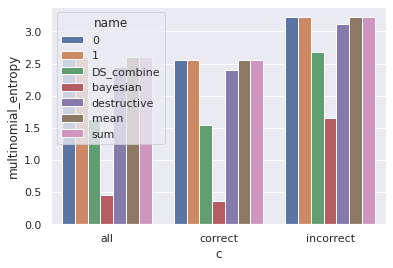

In [43]:
sn.barplot(data=model.metrics, x='c', y='multinomial_entropy', hue='name')

<AxesSubplot:xlabel='name', ylabel='multinomial_entropy'>

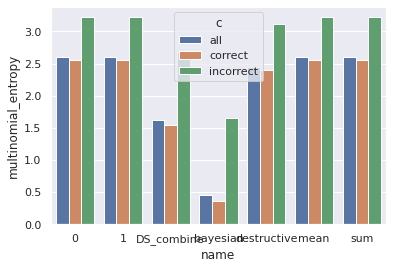

In [44]:
sn.barplot(data=model.metrics, x='name', y='multinomial_entropy', hue='c')

<AxesSubplot:xlabel='name', ylabel='dirchlet_entropy'>

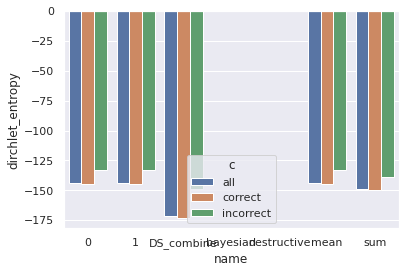

In [46]:
sn.barplot(data=model.metrics, x='name', y='dirchlet_entropy', hue='c')

torch.Size([32, 1, 3, 64, 64]) torch.Size([32, 3, 64, 64])


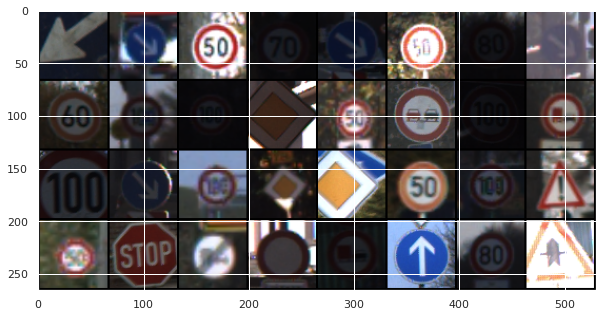

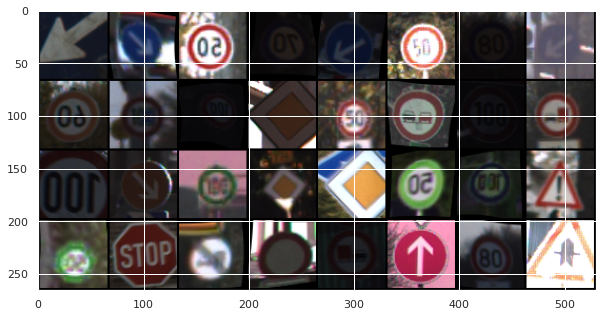

In [39]:
model.show_batch()

In [9]:
class GTSRB_training(LightningModule):
    def __init__(self):
        super().__init__()
        self.n_classes = 43
        # not the best model: expereiment yourself
        self.model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
        #self.model = torchvision.models.resnet18()
        #for param in self.model.parameters():
        #    param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes)
        self.preprocess = Preprocess()  # per sample transforms
        self.transform = DataAugmentation()  # per batch augmentation_kornia
        
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
            
        
        self.train_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes, normalize='true')
        self.valid_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        
        self.learning_rate = 0.006

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, y_hat, y):
        y = F.one_hot(y, self.n_classes)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = evidence_loss.edl_mse_loss(y_hat, y, self.current_epoch, self.n_classes, 10)
   
        #return F.cross_entropy(y_hat, y)
        return loss

    def show_batch(self, win_size=(10, 10)):
        def _to_vis(data):
            return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

        # get a batch from the training set: try with `val_datlaoader` :)
        imgs, labels = next(iter(self.train_dataloader()))
        imgs_aug = self.transform(imgs)  # apply transforms
        print(imgs.shape, imgs_aug.shape)
        #imgs = torch.squeeze(imgs, dim=1)
        # use matplotlib to visualize
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs))
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs_aug))

    def on_after_batch_transfer(self, batch, dataloader_idx):
        x, y = batch
        if self.trainer.training:
            x = self.transform(x)  # => we perform GPU/Batched data augmentation
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.train_accuracy.update(y_hat, y)
        self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", self.train_accuracy, prog_bar=False)
        #self.logger.experiment.add_scalars('loss', {'train': loss}, self.global_step)
        #self.logger.experiment.add_scalars('accuracy', {'train': self.train_accuracy}, self.global_step) 
        
        y_hat = y_hat.argmax(dim=1, keepdim=True)
        self.train_cm(y_hat, y)
        return loss
    
    def training_epoch_end(self, outputs):
        np.save('gtsrb_train_cm.npy', self.train_cm.compute().cpu().numpy())
        self.train_cm.reset()
        

    
    def log_special(self, name, t):
        mean=torch.mean(torch.max(t, dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        median=torch.median(torch.max(t, dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        mean_prob=torch.mean(torch.max(t/torch.sum(t, dim=1, keepdim=True), 
                                            dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        median_prob=torch.median(torch.max(t/torch.sum(t, dim=1, keepdim=True), 
                                            dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        uncertain=torch.mean(self.n_classes/torch.sum(t, dim=1, keepdim=True)).cpu().numpy().round(decimals=2)
        
        return [name, mean, median, mean_prob, median_prob, uncertain]
        

    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x = torch.squeeze(x, dim=1)
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.val_accuracy.update(y_hat, y)
        self.log("valid_loss", loss, prog_bar=False)
        #self.logger.experiment.add_scalars('loss', {'valid': loss}, self.global_step) 
        #self.logger.experiment.add_scalars('accuracy', {'valid': self.val_accuracy}, self.global_step) 
        self.log("valid_acc", self.val_accuracy, prog_bar=True)
                
        
        y_max = y_hat.argmax(dim=1)
   
            
        self.valid_cm(y_max, y)
        
        return loss
    
    def plot_changes(self, x, y, frame0, frame1, fused, fusion_name):
        if (len(x)==0):
            return
        #fig = plt.figure(figsize=(5, 5))
        fig, ax = plt.subplots(figsize=(8,8))

        title = ['Input Image', 'True Mask', 'Predicted Mask']
        
        frame0 = frame0/torch.sum(frame0, dim=1, keepdim=True)
        frame1 = frame1/torch.sum(frame1, dim=1, keepdim=True)
        fused = fused/torch.sum(fused, dim=1, keepdim=True)
        
        both = torch.concat((frame0,frame1,fused), dim=1)
        print ("Total images",len(x))
        
        

        for i, (img, label, f) in enumerate(zip(x, y, both)):
            plt.subplot(len(x),2, (i*2)+1)
            plt.title(label.cpu().numpy())
            plt.imshow(tensor_to_image(img))
            plt.axis('off')
            f=f.reshape(3,self.n_classes)
            plt.subplot(len(x),2, (i*2)+2)
            plt.title(fusion_name)
            plt.imshow(tensor_to_image(f))
            plt.axis('off')
            
        plt.show()    
        # log figure
        self.logger.experiment.add_figure('sample images', fig, global_step=self.global_step)
    
        
    def validation_epoch_end(self, outputs):
        # turn confusion matrix into a figure (Tensor cannot be logged as a scalar)
        fig, ax = plt.subplots(figsize=(8,8))
        #plt.imshow(self.valid_cm.compute().cpu().numpy())
        disp = ConfusionMatrixDisplay(self.valid_cm.compute().cpu().numpy())
        disp.plot(ax=ax)
        
        # log figure
        self.logger.experiment.add_figure('valid_epoch_confmat', fig, global_step=self.global_step)
    
        self.valid_cm.reset()
        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate )
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, 
                                                       steps_per_epoch=len(self.train_dataloader()), 
                                                        epochs=self.trainer.max_epochs),
            'name': 'oncyclelr',
            'interval': 'step', # or 'epoch'
            'frequency': 1
        }
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
        #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
        #                                                       T_max=self.trainer.max_epochs, 
        #                                                      verbose=True)
        #return [optimizer], [scheduler]
        #return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "valid_acc"}
        return [optimizer], [lr_scheduler]

    def prepare_data(self):
        GTSRB(os.getcwd(), 'train', download=True, transform=self.preprocess)
        GTSRB(os.getcwd(), 'test', download=True, transform=self.preprocess)

    def train_dataloader(self):
        dataset = GTSRB(os.getcwd(), 'train', download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=int(16/2))
        return loader

    def val_dataloader(self):
        dataset = GTSRB(os.getcwd(), 'test', download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=int(16/2))
        return loader

In [10]:
model = GTSRB_training()
model.model = torch.load('gtsrb_ce_91.pt')

In [11]:
# Initialize a trainer
trainer = Trainer(
    callbacks=[TQDMProgressBar(refresh_rate=20),
               #StochasticWeightAveraging(swa_lrs=1e-2),
               LearningRateMonitor(logging_interval='step')],
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=1,
)

trainer.fit(model)
# Train the model ⚡
trainer.validate(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 11.2 M
1 | preprocess     | Preprocess       | 0     
2 | transform      | DataAugmentation | 0     
3 | train_accuracy | Accuracy         | 0     
4 | val_accuracy   | Accuracy         | 0     
5 | train_cm       | ConfusionMatrix  | 0     
6 | valid_cm       | ConfusionMatrix  | 0     
----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.794    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 1376 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        valid_acc           0.9349960684776306
       valid_loss           0.5151920318603516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valid_loss': 0.5151920318603516, 'valid_acc': 0.9349960684776306}]

In [8]:
torch.save(model.model, 'gtsrb_ce_91.pt' )

In [12]:
torch.save(model.model, 'gtsrb_evidential_94.pt' )

In [37]:
torch.save(model.model, 'gtsrb_ce_mobilenet.pt' )